In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, Tensor
import torch.optim as optim

from src.utils import load_data

### Load data

In [11]:
X, y, _ = load_data(impute=True)
X_train, X_test = X
y_train, y_test = y
print('Training:\nX-shape: {}, y-shape: {}'.format(X_train.shape, y_train.shape))
print('\nTesting:\nX-shape: {}, y-shape: {}'.format(X_test.shape, y_test.shape))

Training:
X-shape: (1676, 38), y-shape: (1676,)

Testing:
X-shape: (419, 38), y-shape: (419,)


In [12]:
# standardize input features
X_train_mean = X_train.mean(axis=0)
X_train_std = X_train.std(axis=0)
X_train = (X_train - X_train_mean) / X_train_std
X_test = (X_test - X_train_mean) / X_train_std

In [13]:
# Prepare data for model.
if not torch.is_tensor(X_train):
    X_train = torch.tensor(np.array(X_train)).float()
    X_test = torch.tensor(np.array(X_test)).float()
    y_train = torch.tensor(y_train).float()    
    y_test = torch.tensor(y_test).float()

### Define autoencoder

In [14]:
class Autoencoder(nn.Module):
    
    """An autoencoder"""
    
    
    def __init__(self, input_shape, latent_features):
        super(Autoencoder, self).__init__()
        
        self.input_shape = input_shape
        self.latent_features = latent_features
        self.observation_features = np.prod(input_shape)

        # Inference Network
        # Encode the observation `x` into the parameters of the posterior distribution
        # `q_\phi(z|x) = N(z | \mu(x), \sigma(x)), \mu(x),\log\sigma(x) = h_\phi(x)`
        self.encoder = nn.Sequential(
            nn.Linear(in_features=self.observation_features, out_features=32),
            nn.LeakyReLU(),
            nn.Linear(in_features=32, out_features=24),
            nn.Tanh(),
            nn.Linear(in_features=24, out_features=latent_features)
        )
        
        # Generative Model
        # Decode the latent sample `z` into the parameters of the observation model
        # `p_\theta(x | z) = \prod_i B(x_i | g_\theta(x))`
        self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_features, out_features=24),
            nn.Tanh(),
            nn.Linear(in_features=24, out_features=32),
            nn.LeakyReLU(),
            nn.Linear(in_features=32, out_features=self.observation_features)
        )        

    def forward(self, x):
        """Run encoder and decoder, and output latent space together with reconstruction."""
        
        # Latent space
        h = self.encoder(x)

        y = self.decoder(h)
        
        return h, y
    
    def encode(self, x):
        """Run encoder and decoder, and output latent space together with reconstruction."""
        
        # Latent space
        h = self.encoder(x)
        
        return h


In [16]:
latent_features = 18
ae = Autoencoder(X_train.shape[1], latent_features)
print(ae)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=38, out_features=32, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=32, out_features=24, bias=True)
    (3): Tanh()
    (4): Linear(in_features=24, out_features=18, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=18, out_features=24, bias=True)
    (1): Tanh()
    (2): Linear(in_features=24, out_features=32, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=32, out_features=38, bias=True)
  )
)


In [17]:
# Load model.
device = torch.device('cpu' if not torch.cuda.is_available() else 'cuda')
ae.to(device)
print("Running on device", device)

Running on device cpu


Create data loader for batch handling

In [18]:
from torch.utils.data import DataLoader, TensorDataset

data_train = TensorDataset(X_train, y_train)

batch_size = 64
train_loader = torch.utils.data.DataLoader(
    data_train, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True
)

### Train network

In [19]:
from tqdm import tqdm

# Train model.
epochs = 250
eval_every = 1

criterion = nn.MSELoss()
optimizer = optim.Adam(ae.parameters(), lr=0.0007)
train_losses = []
test_losses = []

t = tqdm(range(epochs))
for epoch in t:

    # Training.
    ae.train()    

    for x, _ in train_loader:

        x = x.to(device)
        
        h, x_recon = ae(x)
        
        optimizer.zero_grad()

        # compute training reconstruction loss
        loss = criterion(x_recon, x)
        
        # compute accumulated gradients
        loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
    ae.eval()
    if epoch % eval_every == 0:
        # Train evaluation.
        x = X_train.to(device)
        h, x_recon = ae(x)
        # compute training reconstruction loss
        train_loss = criterion(x_recon, x).item()
        
        x = X_test.to(device)
        h, x_recon = ae(x)
        # compute test reconstruction loss
        test_loss = criterion(x_recon, x).item()
        
        train_losses.append(train_loss)
        test_losses.append(test_loss)
    
    # display the epoch training loss
    t.set_description("epoch : {}/{}, train_loss = {:.4f}, test_loss = {:.4f}".format(epoch + 1, epochs, train_loss, test_loss))
    t.refresh() # to show immediately the update
    

epoch : 250/250, train_loss = 0.1130, test_loss = 0.1240: 100%|██████████| 250/250 [03:03<00:00,  1.36it/s]


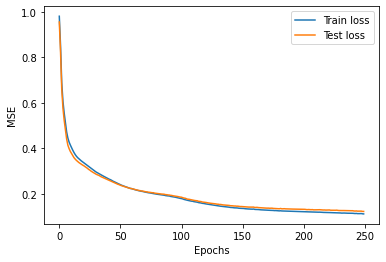

In [20]:
plt.figure()
plt.plot(train_losses, label='Train loss')
plt.plot(test_losses, label='Test loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

Plot example of reconstruction of the 35 features

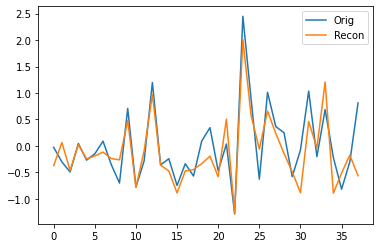

In [23]:
plt.show()
plt.plot(X_train[1], label='Orig')
plt.plot(ae(X_train[1].to(device))[1].detach().cpu().numpy(), label='Recon')
plt.legend()
plt.show()

In [24]:
import pickle
# Save the model to disk.
filename = 'config/autoencoder_v1.pkl'
pickle.dump(ae, open(filename, 'wb'))